# PROJECT : ENSAE Distributed computing course 2021

## Fraud detection using Pyspark utilities

Author : Mohamed Farhat

Goals : 
- Make use of Pyspark in a machine learning context.
- Make use of  Machine learning algorithms for Fraud detection.

<div class="alert alert-block alert-success">
    <h1>Introduction </h1>
</div>

For the distributed computing project, we propose to conceive a machine learning pipeline that we will use for fraud detection. Our choice may be justified by the lack of publicly accessible datasets on financial services,  specifically in the niche domain of mobile money transactions. This lack of data hinders the study of these platforms by researchers and therefore fraud detection systems and system proposals can't advance. However, this data scarcity is due to the intrinsic private nature of the transactions themselves. 

We adapt here a dataset that was generated using PaySim. PaySim uses aggregated data from a given private dataset and then generate a similar synthetic dataset that incorporates the normal transactions but also injects some fraudulent malicious ones which can be used to evaluate the fraud detection system at place. The dataset we have here is taken from **Kaggle** (link provided later on) and it is $\frac{1}{4}$ of its original size.

**About PaySim**

>PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.


<div class="alert alert-block alert-success">
    <h1>Data analysis and ML pipeline </h1>
</div>

<div class="alert alert-info">
    <h2>Part 0: Getting the necessary packages </h2>
</div>

We will here load all the necessary packages/modules for our project

In [6]:
%matplotlib inline
import os
import gdown
import seaborn as sns
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType, IntegerType 
from pyspark.sql.functions import col, sum, mean, max, count, when, lit, udf
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

<div class="alert alert-info">
    <h2>Part 1: The data </h2>
</div>

The Data can be downloaded from kaggle using the following url : [data url](https://www.kaggle.com/ntnu-testimon/paysim1). However for this project, I provide a direct download using this notebook tie saving purposes. 

In [2]:
# Downloading data
url = "https://drive.google.com/uc?id=1YkWjRPb9aeZP0KxWsaDrfgygxILFa6mg"
if not os.path.exists(os.path.join(os.getcwd() , 'data')): # check if the data dir isn't created
    os.mkdir(os.path.join(os.getcwd() , 'data')) # Create data dir if so
data_path = os.path.join(os.getcwd() , 'data', 'fraud_data.csv') # Path to dataset
gdown.download(url, data_path, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=1YkWjRPb9aeZP0KxWsaDrfgygxILFa6mg
To: /distributed_computing_mohamed_farhat_project/data/fraud_data.csv
494MB [01:05, 7.54MB/s] 


Before displaying the data let's define and explain each feature in it  :
- Step :  maps a unit of time in the real world. For example, 1 step is 1 hour. Total steps 744 (30 days simulation).
- Type : CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. (This is more or less self explanatory)
- Amount : The amount of the transaction in local currency.
- nameOrig : The customer who started the transaction.
- oldbalanceOrg : The initial balance before the transaction.
- newbalanceOrig : The new balance after the transaction.
- nameDest : The customer who is the recipient of the transaction.
- oldbalanceDest : The initial balance recipient before the transaction. This is absent for customers who are merchants, these start with M.
- newbalanceDest : The new balance recipient after the transaction. This is absent for customers who are merchants, these start with M.
- isFraud : This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud : The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Now let's have a look at the dataset : 

In [3]:
# Creating a spark context
sc = SparkContext(appName="Fraud detection")
sqlc = SQLContext(sc) 

In [4]:
data = sqlc.read.csv(data_path,header = True) #Reading data

Let's dispaly the First 5 rows in a more elegant pandas manner 

In [5]:
data.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


We can see that there are some two fraud operations happened at the 2nd and 3rd rows without being flagged as such. Aside from 3 non numeric columns of which 2 we would argue are not important for the task, the remaining columns are numeric (in the sense they won't be a problem when casting types).

<div class="alert alert-info">
    <h3>Part 1.1: Data exploration </h3>
</div>

Let's see how many columns our dataframe have, how many fraudulent operations are there and the number of ordinary ones. 

In [7]:
print('\033[1mThe data contain {} rows \033[0m'.format(data.count()))
data.groupBy('isFraud').count().show()

The data contain 6362620 rows 
+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



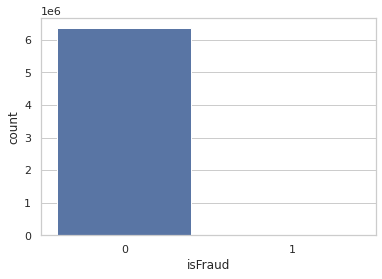

In [8]:
to_plot = data.groupBy('isFraud').count().toPandas()
sns.set_theme(style="whitegrid")
sns.barplot(x="isFraud", y="count", data=to_plot);

We can see that the data have **6 millions** rows out of which **8 thousands** are fraudulent operations or $0.13\%$, which is expected otherwise this would be a thieves world. We are facing an imbalanced dataset case. Now let's see how many data columns contain missing values.

In [9]:
data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



This is a good surprise, there are no missing values in the dataset so we won't be obliged to use imputation techniques and introduce new data. 

<div class="alert alert-info">
    <h3>Part 1.2: The fraudulent fraction </h3>
</div>

In this subsection, we want to understand the behaviour of the fraudsters. 

In [10]:
data.filter(data['isFraud'] == 1).groupby('type').count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 4097|
|CASH_OUT| 4116|
+--------+-----+



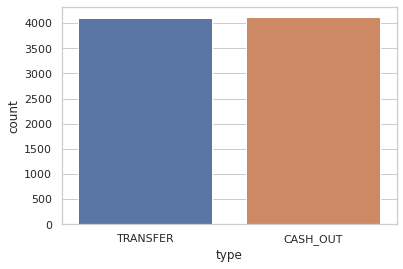

In [11]:
to_plot = data.filter(data['isFraud'] == 1).groupby('type').count().toPandas()
sns.barplot(x="type", y="count", data=to_plot);

We can see that fraudulent operations mainly deal in either **TRANSFER** or **CASH_OUT** in nearly equal proportions. This is more inline with logical explanations as fraudesters tend to take the money as soon as they can so other operations don't make much sense and this is reflected by the data.

Now Let's see how many fraudulent operations have actually been flagged as such :

In [12]:
data.groupby('isFlaggedFraud').count().show()

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



In [13]:
data.filter(data['isFraud'] == 1).groupby('isFlaggedFraud').count().show()

+--------------+-----+
|isFlaggedFraud|count|
+--------------+-----+
|             0| 8197|
|             1|   16|
+--------------+-----+



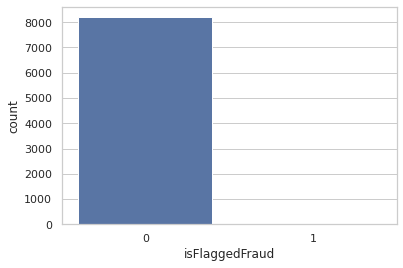

In [14]:
to_plot = data.filter(data['isFraud'] == 1).groupby('isFlaggedFraud').count().toPandas()
sns.barplot(x="isFlaggedFraud", y="count", data=to_plot);

We can see that for more than 8 thousand operations only 16 have been flagged as such which justifies why we want to deal with this problem. Now let's see when an order is flagged as fraud.

In [15]:
data.filter(data['isFlaggedFraud'] == 1).orderBy('amount').show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 646|TRANSFER|     1.0E7|  C19004745|1.039904508E7| 1.039904508E7|C1806199534|           0.0|           0.0|      1|             1|
| 425|TRANSFER|     1.0E7| C689608084|1.958504037E7| 1.958504037E7|C1392803603|           0.0|           0.0|      1|             1|
| 730|TRANSFER|     1.0E7|C2140038573|1.731625505E7| 1.731625505E7|C1395467927|           0.0|           0.0|      1|             1|
| 250|TRANSFER|1343002.08|C1100582606|   1343002.08|    1343002.08|C1147517658|           0.0|           0.0|      1|             1|
| 617|TRANSFER|2542664.27| C786455622|   2542664.27|    2542664.27| C

Eh this isn't very pleasant to read so we will transform it into a pandas dataframe given its small size.

In [16]:
data.filter(data['isFlaggedFraud'] == 1).orderBy('amount').toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,425,TRANSFER,1.0E7,C689608084,1.958504037E7,1.958504037E7,C1392803603,0.0,0.0,1,1
1,646,TRANSFER,1.0E7,C19004745,1.039904508E7,1.039904508E7,C1806199534,0.0,0.0,1,1
2,730,TRANSFER,1.0E7,C2140038573,1.731625505E7,1.731625505E7,C1395467927,0.0,0.0,1,1
3,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
4,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
5,702,TRANSFER,3171085.59,C1892216157,3171085.59,3171085.59,C1308068787,0.0,0.0,1,1
6,671,TRANSFER,3441041.46,C917414431,3441041.46,3441041.46,C1082139865,0.0,0.0,1,1
7,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
8,554,TRANSFER,3576297.1,C193696150,3576297.1,3576297.1,C484597480,0.0,0.0,1,1
9,646,TRANSFER,399045.08,C724693370,1.039904508E7,1.039904508E7,C1909486199,0.0,0.0,1,1


Ah there, it is better now. We can see that the flag is only given if the transaction exceed a certain threshold, which is $200,000$ in the local currency, However the smallest amount here is $10^7$. This approach is not robust to say the least. Let's have a better look at the fraudulent transactions statistics.

In [17]:
print('\033[1mThe maximum amount for a flagged transaction is {}\033[0m'
      .format(data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "max"}).collect()[0][0]))
print('\033[1mThe minimum amount for a flagged transaction is {}\033[0m'
      .format(data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "min"}).collect()[0][0]))

The maximum amount for a flagged transaction is 9585040.37
The minimum amount for a flagged transaction is 1.0E7


Let's see now the average amount for the transactions of each type : flagged or not.

In [18]:
data.groupBy(['isFlaggedFraud']).agg({'amount':'avg','isFlaggedFraud':'count'}).show()

+--------------+------------------+---------------------+
|isFlaggedFraud|       avg(amount)|count(isFlaggedFraud)|
+--------------+------------------+---------------------+
|             0|179850.13041768514|              6362604|
|             1|    4861597.730625|                   16|
+--------------+------------------+---------------------+



We can see that the average for flagged transaction is **27** times greater than that of all the other transactions combined, including the undetected frauds. Albeit this system is great for avoiding tremendous losses it leaves a lot to be desired. 

Just to showcase more functions using pyspark we can redo the previous work using the following code : 

In [19]:
aggr_l = ["amount"] # if one desires more aggregates, one can add them to the list
func_l = [mean, sum, max,count] # Functions to be used for  aggregations
expr_l = [f(col(c)) for f in func_l for c in aggr_l] # expressions list
query_fr = data.groupby("isFlaggedFraud").agg(*expr_l).collect()
query_fr

[Row(isFlaggedFraud='0', avg(amount)=179850.13041768526, sum(amount)=1144315159196.086, max(amount)='99999.81', count(amount)=6362604),
 Row(isFlaggedFraud='1', avg(amount)=4861597.730625, sum(amount)=77785563.69, max(amount)='9585040.37', count(amount)=16)]

We can see that we recovered all the results with a more compact code which is super useful as 5 lines of code can replace dozens. Now, let's see if same origin account are more prone than others, the victims, to being associated with frauds when it is flagged. We will do the same for the destination accounts which is this case would be  the offenders. It is logical to assume that offenders, when they are flagged, commit one or more crimes or maybe they get banned.

In [20]:
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameOrig').count().show()

+-----------+-----+
|   nameOrig|count|
+-----------+-----+
|C2140038573|    1|
|C1684585475|    1|
| C452586515|    1|
| C917414431|    1|
| C724693370|    1|
| C728984460|    1|
| C992223106|    1|
|C1869569059|    1|
|  C19004745|    1|
| C908544136|    1|
|C1035541766|    1|
|C1100582606|    1|
| C689608084|    1|
| C193696150|    1|
| C786455622|    1|
|C1892216157|    1|
+-----------+-----+



Apparently each victim is associated with only one flagged fraud

In [21]:
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameDest').count().show()

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1806199534|    1|
|C1861208726|    1|
|C1147517658|    1|
|C1395467927|    1|
| C661958277|    1|
|C1392803603|    1|
| C484597480|    1|
|C1909486199|    1|
| C639921569|    1|
|C1082139865|    1|
|C1100697970|    1|
|C1770418982|    1|
|C1308068787|    1|
|C1109166882|    1|
| C891140444|    1|
|C1366804249|    1|
+-----------+-----+



Well as expected each account, once flagged for fraud and in this case it happens that each flag is correct, the user is more likely to get banned and therefore no more offenses are commited so one offense is registered for each account.

The same can be said for the **isFraud** column, the reader can check this simply.

<div class="alert alert-info">
    <h3>Part 1.3: The Merchants </h3>
</div>

It was stated in the data description that merchants have the M prefix in their name, however this doesn't seem to be the case
as there is no **CASH_IN** from merchants to customers as we can see below : 

In [22]:
data.filter( (data['type'] == 'CASH_IN') & (data['nameOrig'].like('%M%')) ).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [23]:
data.filter( (data['type'] == 'CASH_OUT') & (data['nameOrig'].like('%M%')) ).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [24]:
data.filter(data['nameDest'].like('%M%')).groupBy('type').count().show()

+-------+-------+
|   type|  count|
+-------+-------+
|PAYMENT|2151495|
+-------+-------+



We can see that merchants only figure in the payment category and in the destination of a given payment.

<div class="alert alert-info">
    <h2>Part 2: Data cleaning </h2>
</div>

<div class="alert alert-info">
    <h3>Part 2.1: Changing the target category </h3>
</div>

For some cases, mainly those which are involved in the fraud (see previous part), we will change the value of the associated amounts in the **oldbalanceDest** from **0** to **-1**. 

In [25]:
fraud_dest = data.filter(data['type'].isin(['CASH_OUT','TRANSFER']))
fraud_dest = fraud_dest.withColumn('oldbalanceDest', when((fraud_dest['oldbalanceDest'] == 0) \
                & (fraud_dest['newbalanceDest'] ==0) & \
                (fraud_dest['amount'] !=0), -1).otherwise(fraud_dest['oldbalanceDest']))

fraud_dest = fraud_dest.withColumn('newbalanceDest', when((fraud_dest['oldbalanceDest'] == 0) \
                & (fraud_dest['newbalanceDest'] ==0) & \
                (fraud_dest['amount'] !=0), -1).otherwise(fraud_dest['newbalanceDest']))

Let's double check the results

In [26]:
fraud_dest.agg({"oldbalanceDest": "min"}).collect()[0]

Row(min(oldbalanceDest)='-1')

<div class="alert alert-info">
    <h3>Part 2.2: Changing data types </h3>
</div>

Here we will change the type of the transactions into numeric type along with the fraud column and then rename it to **label**

In [27]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(fraud_dest) for column in ['type']]
pipeline = Pipeline(stages=indexers)
fraud_dest_num = pipeline.fit(fraud_dest).transform(fraud_dest)

In [28]:
final_data = fraud_dest_num.withColumn('type_index',fraud_dest_num['type_index'].cast(IntegerType()))
final_data = final_data.withColumn('isFraud',fraud_dest_num['isFraud'].cast(IntegerType()))
final_data = final_data.withColumnRenamed('isFraud','label') # Just renaming the target
final_data = final_data.drop('type') # dropping unnecessary columns

Let's see the final dataframe

In [29]:
final_data.limit(10).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1
5,1,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0,0
6,1,56953.9,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0,0
7,1,5346.89,C512549200,0.0,0.0,C248609774,652637.0,6453430.91,0,0,0
8,1,23261.3,C2072313080,20411.53,0.0,C2001112025,25742.0,0.0,0,0,0
9,1,62610.8,C1976401987,79114.0,16503.2,C1937962514,517.0,8383.29,0,0,1


<div class="alert alert-info">
    <h2>Part 3: Feature engineering </h2>
</div>

Here we will try to introduce some new features useful for our predictions. Here we will introduce the difference between the new balance and the old one in the origin and the destination columns.

In [30]:
final_data = final_data.withColumn("errorbalanceOrig", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg"))
final_data = final_data.withColumn("errorbalanceDest", col("oldbalanceDest") + col("amount") - col("newbalanceDest"))
final_data.limit(10).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index,errorbalanceOrig,errorbalanceDest
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1,0.00,180.00
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0,0.00,21363.00
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,213808.94,182703.50
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1,214605.30,237735.30
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,300850.89,-2401220.00
5,1,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0,0,83569.30,396799.55
6,1,56953.9,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0,0,55011.88,63100.72
7,1,5346.89,C512549200,0.0,0.0,C248609774,652637.0,6453430.91,0,0,0,5346.89,-5795447.02
8,1,23261.3,C2072313080,20411.53,0.0,C2001112025,25742.0,0.0,0,0,0,2849.77,49003.30
9,1,62610.8,C1976401987,79114.0,16503.2,C1937962514,517.0,8383.29,0,0,1,0.00,54744.51


That's it for adding new features, sadly. Now let's divide it to target and features frame. 

Now we will convert the literal attributes (strings) into numeric type for the adequate columns, as strings are not useful for our predictions later.

In [31]:
final_data.dtypes

[('step', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

In [32]:
string_types = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
for elem in string_types:
    final_data = final_data.withColumn(elem, col(elem).cast('float'))

In [33]:
final_data.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'float'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

<div class="alert alert-info">
    <h2>Part 4: Prediction </h2>
</div>

In this part we will try to construct a predictor for our problem at hand using pyspark ML utilities

<div class="alert alert-info">
    <h3>Part 4.1: Train-Test Split </h3>
</div>

As we have seen our dataset is highly imbalanced so we will use a stratified split to overcome this.

In [34]:
fracs = final_data.select("label").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
train = final_data.sampleBy('label',fracs,seed=42)
test = final_data.subtract(train)

<div class="alert alert-info">
    <h3>Part 4.2: ML pipeline </h3>
</div>

In [35]:
target, features = ['label'], ['step','type_index','amount','oldbalanceOrg','newbalanceOrig', 
                               'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]

Let's use PCA for reducing the dimensionality of the data as we are not sure which of the features is most adequate for the prediction. We will keep the 5 most relevant features, this is not the best approach but it yields good results later so we will keep it. First let's vectorise the dataframe first.

In [39]:
vect_data = VectorAssembler(inputCols=features, outputCol="features_vct")

In [40]:
pca = PCA(k=5, inputCol="features_vct", outputCol="features_pca")

We are going to use a random forest classifier so let's create a classifier

In [41]:
random_forest = RandomForestClassifier(labelCol="label", featuresCol="features_pca")

Now, let's put together the pipeline

In [42]:
pipeline = Pipeline(stages=[vect_data, pca, random_forest])

And finally a multi-label evaluator 

In [43]:
eval_classif = MulticlassClassificationEvaluator()  

<div class="alert alert-info">
    <h3>Part 4.3: Hyper parameter search </h3>
</div>

We will employ a grid search to find the optimal parameters for our model

In [44]:
#Building the parameter grid for the random forest
param_grid = (ParamGridBuilder()
             .addGrid(random_forest.maxDepth, [2, 4, 6])
             .addGrid(random_forest.maxBins, [20, 60])
             .addGrid(random_forest.numTrees, [5, 20])
             .addGrid(random_forest.impurity, ['gini', 'entropy']) # splitting criterion inside the tree 
             .build())

Let's also code a validation and an evaluation function 

In [45]:
def validation(criterion='cross_validation'):
    if criterion == 'cross_validation':
        return CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=param_grid,
            evaluator=eval_classif,
            numFolds=10)
    
    elif criterion == 'train_test_splits': 
        return TrainValidationSplit(
            estimator=pipeline,
            estimatorParamMaps=param_grid,
            evaluator=eval_classif,
            trainRatio=0.8)
    else:
        print('The validation criterion can either be \033[1m cross_validation\033[0m or \033[1mtrain_test_splits\033[0m')
        return None

This function evaluates the model quantitatively via accuracy computation

In [46]:
def evaluation(model, train, test):
    pred = model.transform(train)
    acc = eval_classif.evaluate(pred)
    test_pred = model.transform(test)
    test_acc = eval_classif.evaluate(test_pred)
    print('\033[1mtrain_acc:\033[0m{}, \033[1mtest_acc:\033[0m{}'.format(acc, test_acc))
    return pred, test_pred

Let's see first check the columns of the train frame

In [47]:
train.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'float'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

All seems good, let's now try to find the most adequate model

In [48]:
validated = validation() # using cross validation
cross_val_models = validated.fit(train)

In [49]:
best_overall = cross_val_models.bestModel
preds = best_overall.transform(train)
eval_classif.evaluate(preds)

0.9983506322042504

That's seems to be a pretty good result, let's see what are the best parameters

In [194]:
print('\033[1mThe best impurity criterion is:\033[0m {}'.format(best_overall.stages[-1]._java_obj.getImpurity()))
print('\033[1mThe best choice for the maximum depth is:\033[0m {}'
      .format(best_overall.stages[-1]._java_obj.getMaxDepth()))
print('\033[1mThe best choice for the maximum number of bins is:\033[0m {}'
      .format(best_overall.stages[-1]._java_obj.getMaxBins()))
print('\033[1mThe best choice for the number of trees is:\033[0m {}'
      .format(best_overall.stages[-1]._java_obj.getNumTrees()))

The best impurity criterion is: gini
The best choice for the maximum depth is: 6
The best choice for the maximum number of bins is: 60
The best choice for the number of trees is: 5


<div class="alert alert-info">
    <h3>Part 4.4: Model evaluation  </h3>
</div>

Now let's evaluate the model using notions like accuracy, precision and recall. Let's see how the model is doing.

In [209]:
pred, test_pred = evaluation(cross_val_models, train, test)

train_acc:0.9983304329822252, test_acc:0.9983650475099156


In [205]:
# Changing matplotlib default style
plt.style.use('ggplot')

We will introduce 2 functions that compute the confusion matrix and the various metrics that we can see below.

In [217]:
def reporter(train_trg, test_trg, train_pred, test_pred, classes):
    figure, axes = plt.subplots(1, 2, figsize=(10,5))
    conf_mat = confusion_matrix(test_trg, test_pred)
    conf_mat_frame = pd.DataFrame(conf_mat, index = classes, columns = classes)
    ax = sns.heatmap(conf_mat_frame, annot=True, ax = axes[0], square= True)
    ax.set_title('Confusion matrix for Test')
    conf_mat = confusion_matrix(train_trg, train_pred)
    conf_mat_frame = pd.DataFrame(conf_mat, index = classes, columns = classes)
    ax = sns.heatmap(conf_mat_frame, annot=True, ax = axes[1], square= True)
    ax.set_title('confusion matrix for Train')
    print('\033[1m Testing results \033[0m')
    print(classification_report(test_trg, test_pred, target_names = classes))
    print('acc: ', metrics.accuracy_score(test_trg, test_pred))
    print('\033[1m Training results \033[0m')
    print(classification_report(train_trg, train_pred, target_names = classes))
    print('acc: ', metrics.accuracy_score(train_trg, train_pred))

def classif_reporter(model, train, test, features, target):
    train_classes = np.unique(train[target].values).tolist()
    test_classes = np.unique(test[tarrget].values).tolist()
    assert (train_classes == test_classes)
    train_feat = train[features].values.tolist()
    test_feat = test[features].values.tolist()
    train_trg = df_train[target].values.tolist()
    test_trg = df_test[y_feature].values.tolist()
    train_pred = model.predict(train_feat)
    test_pred = model.predict(test_feat)
    reporter(train_trg, test_trg, train_pred, test_pred, train_classes)

 Testing results 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    551717
           1       0.89      0.57      0.69      1632

    accuracy                           1.00    553349
   macro avg       0.95      0.78      0.85    553349
weighted avg       1.00      1.00      1.00    553349

acc:  0.9985289573126545
 Training results 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2210479
           1       0.90      0.56      0.69      6581

    accuracy                           1.00   2217060
   macro avg       0.95      0.78      0.84   2217060
weighted avg       1.00      1.00      1.00   2217060

acc:  0.9985043255482485


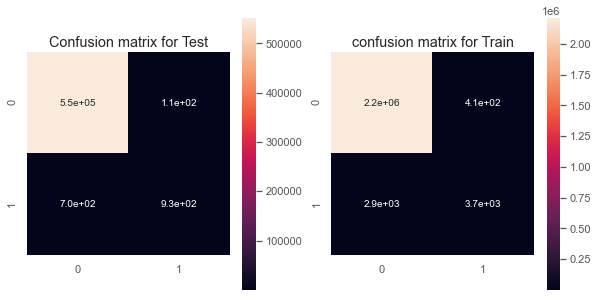

In [218]:
train_trg = pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
train_pred = pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()
test_trg = test_pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
test_pred_star = test_pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()
reporter(train_trg, test_trg, train_pred, test_pred_star, ['0', '1'])

In [220]:
display(pred.select("label", "prediction", "probability").show(10))

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       0.0|[0.98994318504618...|
|    1|       0.0|[0.99859857064750...|
|    0|       0.0|[0.99969679972571...|
|    0|       0.0|[0.99790438921459...|
|    0|       0.0|[0.99969679972571...|
|    0|       0.0|[0.99790438921459...|
|    0|       0.0|[0.99837865492825...|
|    0|       0.0|[0.99969679972571...|
|    0|       0.0|[0.99816533534706...|
|    0|       0.0|[0.99879059111698...|
+-----+----------+--------------------+
only showing top 10 rows



None

We can see that the model achieves satisfactory results. 

<div class="alert alert-block alert-success">
    <h1>Conclusion </h1>
</div>

We have successfully used **Pyspark** to analyse a dataset of a considerable size (at least for a local machine), we have also used the ML utilities it provides to conceive a pipeline that achieves very good results for fraud detection.